In [ ]:
import os
import numpy as np
import cv2
import torch
from PIL import Image
from datetime import datetime
import matplotlib.pyplot as plt

from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

In [ ]:
timestamp = datetime.now().strftime("%m%d%H%M")
output_dir = f"result2/{timestamp}"
os.makedirs(output_dir, exist_ok=True)

edge_image_path = "images/circular_denoised_image.png"
edge_image = cv2.imread(edge_image_path, cv2.IMREAD_GRAYSCALE)

edges = cv2.Canny(edge_image, 50, 150)
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

coordinates = []
for contour in contours:
    for point in contour:
        x, y = point[0]
        coordinates.append([x, y])

input_point = np.array(coordinates)
input_label = np.ones(len(input_point), dtype=int)


coordinates_output_path = os.path.join(output_dir, "coordinates.csv")
np.savetxt(coordinates_output_path, input_point, delimiter=",", fmt="%d", header="x,y")
print(f"Edge 이미지에서 추출된 좌표가 저장되었습니다: {coordinates_output_path}")
print(f"총 추출된 좌표: {len(input_point)}개")

adapt_image_path = "images/preprocessed_image.png"
adapt_image = Image.open(adapt_image_path)
adapt_image = np.array(adapt_image.convert("RGB"))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

sam2_checkpoint = "../checkpoints/sam2.1_hiera_tiny.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_t.yaml"
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)
predictor = SAM2ImagePredictor(sam2_model)
predictor.set_image(adapt_image)

masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

sorted_ind = np.argsort(scores)[::-1]
masks = masks[sorted_ind]
scores = scores[sorted_ind]
logits = logits[sorted_ind]

In [ ]:
def save_combined_cropped_image(image, masks, points, labels, output_path):
    h, w, _ = image.shape
    combined_image = np.ones_like(image, dtype=np.uint8) * 255

    for i, point in enumerate(points):
        x, y = point
        if labels[i] == 1:  #
            for j, mask in enumerate(masks):
                if mask[y, x] == 1:
                    masked_image = cv2.bitwise_and(image, image, mask=(mask * 255).astype(np.uint8))
                    combined_image[mask > 0] = masked_image[mask > 0]

    cv2.imwrite(output_path, cv2.cvtColor(combined_image, cv2.COLOR_RGB2BGR))
    print(f"Combined cropped image 저장 완료: {output_path}")

combined_output_path = os.path.join(output_dir, "combined_cropped_result.png")
save_combined_cropped_image(adapt_image, masks, input_point, input_label, combined_output_path)

In [ ]:
def show_mask(mask, ax, random_color=False, borders=True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2)
    ax.imshow(mask_image)

In [ ]:
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], coords[labels == 0], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

In [ ]:
def show_masks(image, masks, scores, point_coords, input_labels, output_dir):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca())
        show_points(point_coords, input_labels, plt.gca())
        plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        output_path = os.path.join(output_dir, f"visualized_mask_{i+1}.png")
        plt.savefig(output_path)
        print(f"Segmentation 시각화 마스크 {i+1} 저장 완료: {output_path}")

In [ ]:
show_masks(adapt_image, masks, scores, input_point, input_label, output_dir)

Edge 이미지에서 추출된 좌표가 저장되었습니다: result2/12101549/coordinates.csv
총 추출된 좌표: 35563개
Using device: cuda
Combined cropped image 저장 완료: result2/12101549/combined_cropped_result.png
Segmentation 시각화 마스크 1 저장 완료: result2/12101549/visualized_mask_1.png
Segmentation 시각화 마스크 2 저장 완료: result2/12101549/visualized_mask_2.png
Segmentation 시각화 마스크 3 저장 완료: result2/12101549/visualized_mask_3.png
Segmentation 결과와 합쳐진 이미지가 result2/12101549에 저장되었습니다.


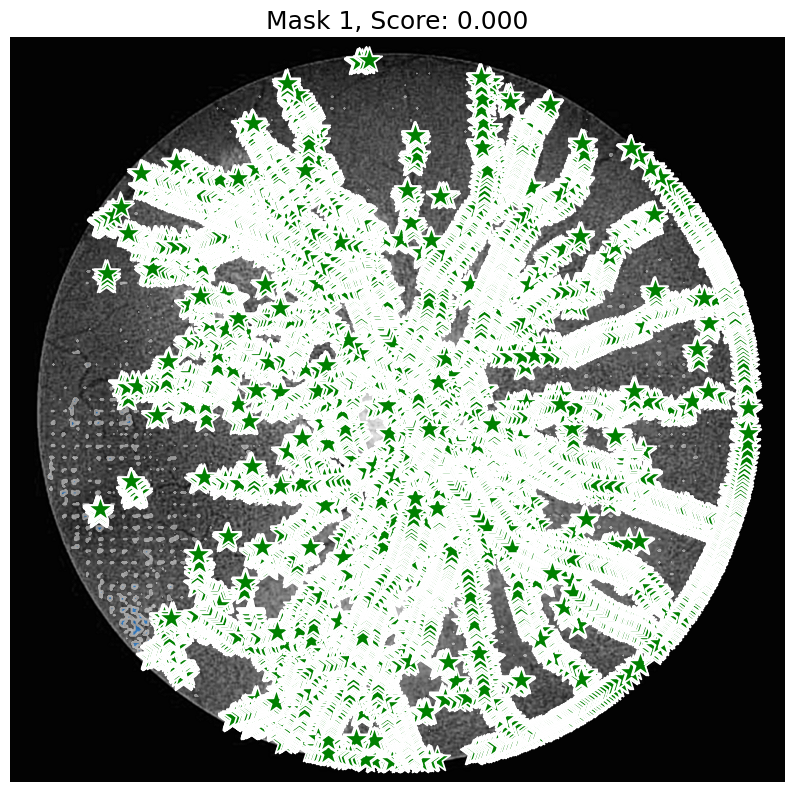

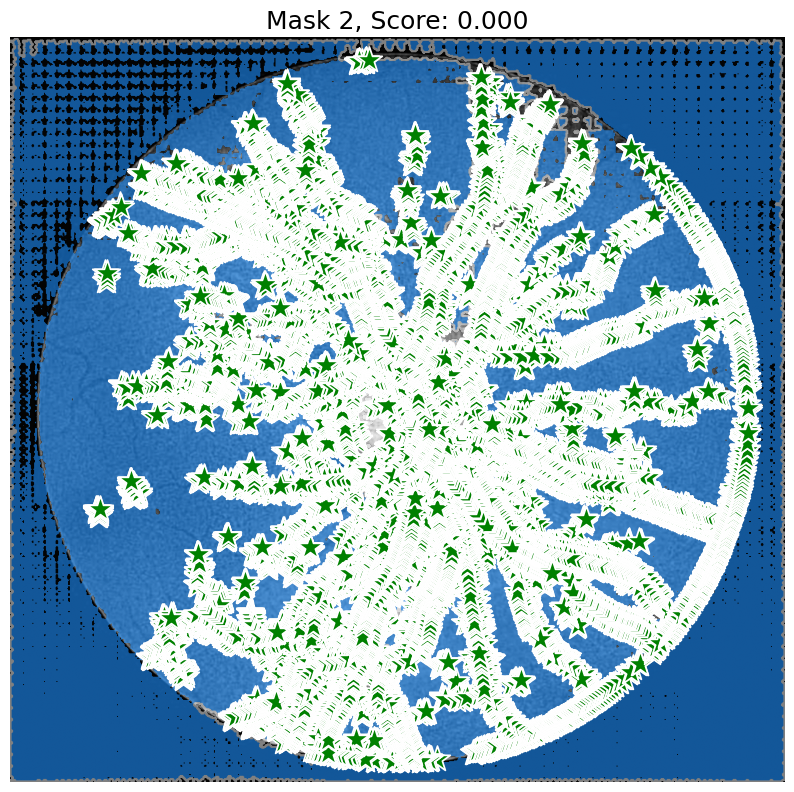

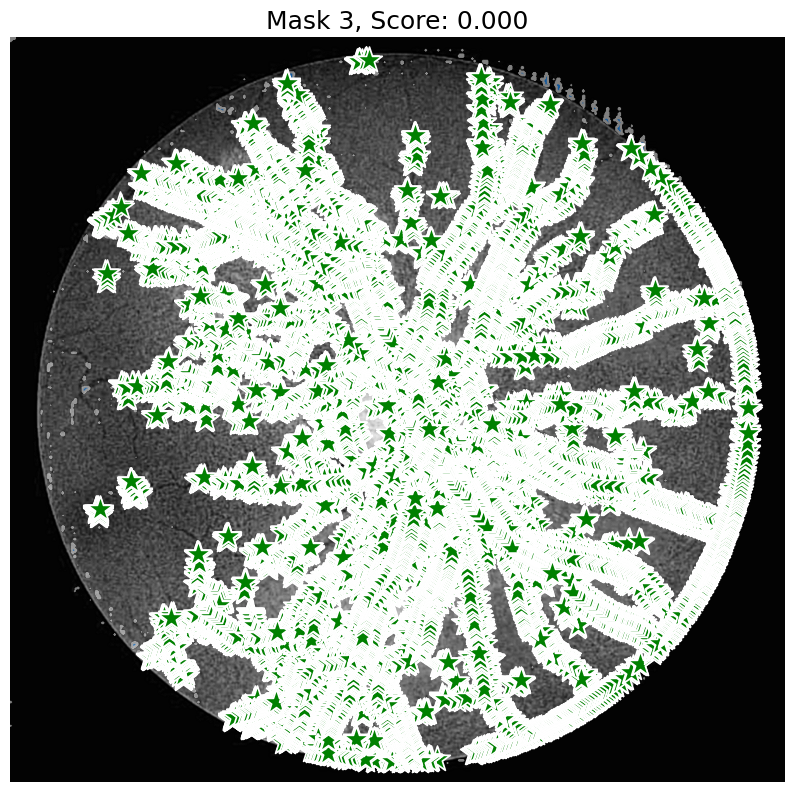

In [ ]:
print(f"Segmentation 결과와 합쳐진 이미지가 {output_dir}에 저장되었습니다.")